In [1]:
import torch
import os
import cv2
import selectivesearch
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
 

In [2]:
# Define the paths to the image folder and annotations
images_path = "../Potholes/annotated-images"
annotations_path = "../Potholes/annotated-images"

### HIGHER SIZE, MORE SELECTIVE BOXES BUT SLOWER
TARGET_WIDTH, TARGET_HEIGHT = 600, 600


# %%
# Helper function to parse the XML file for ground truth bounding boxes
def parse_xml(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()
    boxes = []
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        boxes.append((xmin, ymin, xmax, ymax))

    return boxes

In [3]:
# Helper function to display an image with bounding boxes
def visualize_image(image, boxes, proposals=None, scale_x=1.0, scale_y=1.0):
    # Adjust ground truth boxes according to the scale
    adjusted_boxes = [(int(xmin * scale_x), int(ymin * scale_y), int(xmax * scale_x), int(ymax * scale_y)) for xmin, ymin, xmax, ymax in boxes]
    
    # Convert color for display
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Draw ground truth boxes in blue
    for (xmin, ymin, xmax, ymax) in adjusted_boxes:
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    
    # Draw Selective Search proposals in green if provided
    if proposals:
        for (x, y, w, h) in proposals:
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
    
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [4]:
# Function to run Selective Search and obtain proposals
def get_proposals(image):
    _, regions = selectivesearch.selective_search(image, scale=600, sigma=0.8, min_size=100)
    proposals = []
    for r in regions:
        if r['rect'] in proposals:
            continue
        x, y, w, h = r['rect']
        if w > 20 and h > 20:  # Filter small regions
            proposals.append((x, y, w, h))
    return proposals

c:\Users\Leuro\anaconda3\envs\DL\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


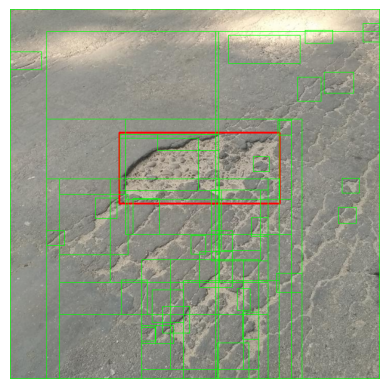

KeyboardInterrupt: 

In [5]:
# Loop through images, resize if needed, and apply Selective Search
for image_filename in os.listdir(images_path):
    if image_filename.endswith(".jpg"):
        image_path = os.path.join(images_path, image_filename)
        xml_filename = image_filename.replace(".jpg", ".xml")
        xml_path = os.path.join(annotations_path, xml_filename)

        image = cv2.imread(image_path)
        
        # Calculate scaling factors
        orig_height, orig_width = image.shape[:2]
        scale_x = TARGET_WIDTH / orig_width
        scale_y = TARGET_HEIGHT / orig_height

        # Resize the image to improve Selective Search efficiency
        resized_image = cv2.resize(image, (TARGET_WIDTH, TARGET_HEIGHT))

        # Run Selective Search on resized image
        proposals = get_proposals(resized_image)

        if os.path.exists(xml_path):
            boxes = parse_xml(xml_path)
            visualize_image(resized_image, boxes, proposals[:], scale_x=scale_x, scale_y=scale_y)  # To Display uncomment

        # Break to only visualize a few images
        # if len(proposals) > 10:
        #     break

## TO DO: METRICS: RECALL AND MABO

## Evaluate Proposals by Calculating Recall

Recall=  Total number of ground-truth boxes / Number of detected ground-truth boxes

In [44]:
# Constants
IOU_THRESHOLD = 0.5  # For recall calculation
TARGET_PROPOSALS = range(10, 200, 10)  # Range of number of proposals to test (adjust as needed)

# Helper function to calculate IoU between two bounding boxes
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou